In [1]:
import Pegasus
print(Pegasus.__file__)

/usr/lib64/python3.6/site-packages/Pegasus/__init__.py


In [2]:
from IPython.display import Image
from Pegasus.api import *
from pathlib import Path
import logging
import os

logging.basicConfig(level=logging.DEBUG)
WF_DIR = Path(".").resolve()

In [3]:
# --- Properties ---------------------------------------------------------------
props = Properties()
props["pegasus.monitord.encoding"] = "json"                                                                    
props["pegasus.mode"] = "development"

props.write()

In [4]:
# --- Input files locations ---------------------------------------------------
INPUT_FASTA_FILE = WF_DIR/'input/GA98.fasta'
UNIREF90_DB_PATH = WF_DIR/'input/uniref90_chunk.fasta'
PDB70_DB_DIR = "/local-scratch/mzalam/alpha2/data/pdb70/"
MGNIFY_DB_PATH = WF_DIR/'input/mgnify_chunk.fa'
BFD_DB_PATH = WF_DIR/'input/bfd_chunk.fasta'

In [5]:
# --- Replicas -----------------------------------------------------------------
rc = ReplicaCatalog()

protein_sequence_input = File("GA98.fasta")
rc.add_replica("local",protein_sequence_input,INPUT_FASTA_FILE)

uniref90_db = File("uniref90.fasta")
rc.add_replica("local",uniref90_db,UNIREF90_DB_PATH)

pdb1 = File("md5sum")
rc.add_replica("local",pdb1,"/local-scratch/mzalam/alpha2/data/pdb70/md5sum")

pdb2 = File("pdb70_a3m.ffdata")
rc.add_replica("local",pdb2,"/local-scratch/mzalam/alpha2/data/pdb70/pdb70_a3m.ffdata")

pdb3 = File("pdb70_a3m.ffindex")
rc.add_replica("local",pdb3,"/local-scratch/mzalam/alpha2/data/pdb70/pdb70_a3m.ffindex")

pdb4 = File("pdb70_clu.tsv")
rc.add_replica("local",pdb4,"/local-scratch/mzalam/alpha2/data/pdb70/pdb70_clu.tsv")

pdb5 = File("pdb70_cs219.ffdata")
rc.add_replica("local",pdb5,"/local-scratch/mzalam/alpha2/data/pdb70/pdb70_cs219.ffdata")

pdb6 = File("pdb70_cs219.ffindex")
rc.add_replica("local",pdb6,"/local-scratch/mzalam/alpha2/data/pdb70/pdb70_cs219.ffindex")

pdb7 = File("pdb70_hhm.ffdata")
rc.add_replica("local",pdb7,"/local-scratch/mzalam/alpha2/data/pdb70/pdb70_hhm.ffdata")

pdb8 = File("pdb70_hhm.ffindex")
rc.add_replica("local",pdb8,"/local-scratch/mzalam/alpha2/data/pdb70/pdb70_hhm.ffindex")

pdb9 = File("pdb_filter.dat")
rc.add_replica("local",pdb9,"/local-scratch/mzalam/alpha2/data/pdb70/pdb_filter.dat")

mgnify_db = File("mgnify.fa")
rc.add_replica("local",mgnify_db,MGNIFY_DB_PATH)

bfd_db = File("bfd.fasta")
rc.add_replica("local",bfd_db,BFD_DB_PATH)

rc.write()

In [6]:
# --- Sites ----------------------------------------------------------
sc = SiteCatalog()

shared_scratch_dir = os.path.join(WF_DIR, "scratch")
local_storage_dir = os.path.join(WF_DIR, "outputs")

local = Site("local")\
        .add_directories(
                        Directory(Directory.SHARED_SCRATCH, shared_scratch_dir, shared_file_system=True)
                            .add_file_servers(FileServer("file://" + shared_scratch_dir, Operation.ALL)),
                        
                        Directory(Directory.LOCAL_STORAGE, local_storage_dir, shared_file_system=True)
                            .add_file_servers(FileServer("file://" + local_storage_dir, Operation.ALL))
                        )

condorpool = Site("condorpool")\
                .add_condor_profile(universe="vanilla")\
                .add_pegasus_profile(
                    style="condor",
                    data_configuration="condorio"
                )

sc.add_sites(local,condorpool)
sc.write()

defaultdict(<class 'collections.OrderedDict'>, {})
defaultdict(<class 'collections.OrderedDict'>, {})


In [7]:
# --- Transformations ----------------------------------------------------------

tc = TransformationCatalog()

singularity_container = Container(
                  "singularity-container",
                  Container.SINGULARITY,
                  image="/local-scratch/mzalam/alpha2/my_container.sif",
                  image_site="local",
                  bypass_staging=True
               )
tc.add_containers(singularity_container)


sequence_features = Transformation(
                "sequence_features",
                site="condorpool",
                pfn= WF_DIR/"bin/sequence_features.py",
                is_stageable=True,
                arch=Arch.X86_64,
                os_type=OS.LINUX,
                container=singularity_container
            )


jackhmmer_uniref90 = Transformation(
                "jackhmmer_uniref90",
                site="condorpool",
                pfn= WF_DIR/"bin/jackhmmer_uniref90.py",
                is_stageable=True,
                arch=Arch.X86_64,
                os_type=OS.LINUX,
                container=singularity_container
            )

hhsearch_pdb70 = Transformation(
                "hhsearch_pdb70",
                site="condorpool",
                pfn= WF_DIR/"bin/hhsearch_pdb70.py",
                is_stageable=True,
                arch=Arch.X86_64,
                os_type=OS.LINUX,
                container=singularity_container
            )

jackhmmer_mgnify = Transformation(
                "jackhmmer_mgnify",
                site="condorpool",
                pfn= WF_DIR/"bin/jackhmmer_mgnify.py",
                is_stageable=True,
                arch=Arch.X86_64,
                os_type=OS.LINUX,
                container=singularity_container
            )

hhblits_bfd = Transformation(
                "hhblits_bfd",
                site="condorpool",
                pfn= WF_DIR/"bin/hhblits_bfd.py",
                is_stageable=True,
                arch=Arch.X86_64,
                os_type=OS.LINUX,
                container=singularity_container
            )

msa_features = Transformation(
                "msa_features",
                site="condorpool",
                pfn= WF_DIR/"bin/msa_features.py",
                is_stageable=True,
                arch=Arch.X86_64,
                os_type=OS.LINUX,
                container=singularity_container
            )

features_summary = Transformation(
                "features_summary",
                site="condorpool",
                pfn= WF_DIR/"bin/features_summary.py",
                is_stageable=True,
                arch=Arch.X86_64,
                os_type=OS.LINUX
            )

combine_features = Transformation(
                "combine_features",
                site="condorpool",
                pfn= WF_DIR/"bin/combine_features.py",
                is_stageable=True,
                arch=Arch.X86_64,
                os_type=OS.LINUX,
                container=singularity_container
            )

tc.add_transformations(sequence_features,
                       jackhmmer_uniref90,
                       hhsearch_pdb70,
                       jackhmmer_mgnify,
                       hhblits_bfd,
                       msa_features,
                       features_summary,
                       combine_features)

tc.write()

In [8]:
wf = Workflow("Alphafold-workflow")

sequence_features_file = File('sequence_features.pkl')
job_sequence_features = Job(sequence_features)\
            .add_args(protein_sequence_input,sequence_features_file)\
            .add_inputs(protein_sequence_input)\
            .add_outputs(sequence_features_file)
wf.add_jobs(job_sequence_features)

uniref90_msa = File('uniref90_hits.sto')
uniref90_msa_size = File('uniref90_msa_size.txt')
job_jackhmmer_msa = Job(jackhmmer_uniref90)\
            .add_args(protein_sequence_input,uniref90_db,uniref90_msa,uniref90_msa_size)\
            .add_inputs(protein_sequence_input,uniref90_db)\
            .add_outputs(uniref90_msa,uniref90_msa_size)
wf.add_jobs(job_jackhmmer_msa)

pdb70_hits = File('pdb70_hits.hhr')
job_pdb70_search = Job(hhsearch_pdb70)\
            .add_args(".",uniref90_msa,pdb70_hits)\
            .add_inputs(pdb1,pdb2,pdb3,pdb4,pdb5,pdb6,pdb7,pdb8,pdb9,uniref90_msa)\
            .add_outputs(pdb70_hits)
wf.add_jobs(job_pdb70_search)

mgnify_msa = File('mgnify_hits.sto')
mgnify_msa_size = File('mgnify_msa_size.txt')
job_mgnify_msa = Job(jackhmmer_mgnify)\
            .add_args(protein_sequence_input,mgnify_db,mgnify_msa,mgnify_msa_size)\
            .add_inputs(protein_sequence_input,mgnify_db)\
            .add_outputs(mgnify_msa,mgnify_msa_size)
wf.add_jobs(job_mgnify_msa)

bfd_msa = File('bfd_hits.sto')
bfd_msa_size = File('bfd_msa_size.txt')
job_bfd_msa = Job(hhblits_bfd)\
            .add_args(protein_sequence_input,bfd_db,bfd_msa,bfd_msa_size)\
            .add_inputs(protein_sequence_input,bfd_db)\
            .add_outputs(bfd_msa,bfd_msa_size)
wf.add_jobs(job_bfd_msa)

msa_features_file = File('msa_features_file.pkl')
final_msa_size = File('final_msa_size.txt')
job_msa_features = Job(msa_features)\
            .add_args(uniref90_msa,mgnify_msa,bfd_msa,msa_features_file,final_msa_size)\
            .add_inputs(uniref90_msa,mgnify_msa,bfd_msa)\
            .add_outputs(msa_features_file,final_msa_size)
wf.add_jobs(job_msa_features)

summary_file = File('features_summary.txt')
job_features_summary = Job(features_summary)\
            .add_args(uniref90_msa_size,mgnify_msa_size,bfd_msa_size,final_msa_size,summary_file)\
            .add_inputs(uniref90_msa_size,mgnify_msa_size,bfd_msa_size,final_msa_size)\
            .add_outputs(summary_file)
wf.add_jobs(job_features_summary)

features_file = File('features.pkl')
job_combine_features = Job(combine_features)\
            .add_args(sequence_features_file,msa_features_file,pdb70_hits,features_file)\
            .add_inputs(sequence_features_file,msa_features_file,pdb70_hits)\
            .add_outputs(features_file)
wf.add_jobs(job_combine_features)


INFO:Pegasus.api.workflow:Alphafold-workflow added Job(_id=ID0000001, transformation=sequence_features)
INFO:Pegasus.api.workflow:Alphafold-workflow added Job(_id=ID0000002, transformation=jackhmmer_uniref90)
INFO:Pegasus.api.workflow:Alphafold-workflow added Job(_id=ID0000003, transformation=hhsearch_pdb70)
INFO:Pegasus.api.workflow:Alphafold-workflow added Job(_id=ID0000004, transformation=jackhmmer_mgnify)
INFO:Pegasus.api.workflow:Alphafold-workflow added Job(_id=ID0000005, transformation=hhblits_bfd)
INFO:Pegasus.api.workflow:Alphafold-workflow added Job(_id=ID0000006, transformation=msa_features)
INFO:Pegasus.api.workflow:Alphafold-workflow added Job(_id=ID0000007, transformation=features_summary)
INFO:Pegasus.api.workflow:Alphafold-workflow added Job(_id=ID0000008, transformation=combine_features)


INFO:Pegasus.api.workflow:inferring Alphafold-workflow dependencies
INFO:Pegasus.api.workflow:workflow Alphafold-workflow with 8 jobs generated and written to workflow.yml

####################
# pegasus-graphviz #
####################


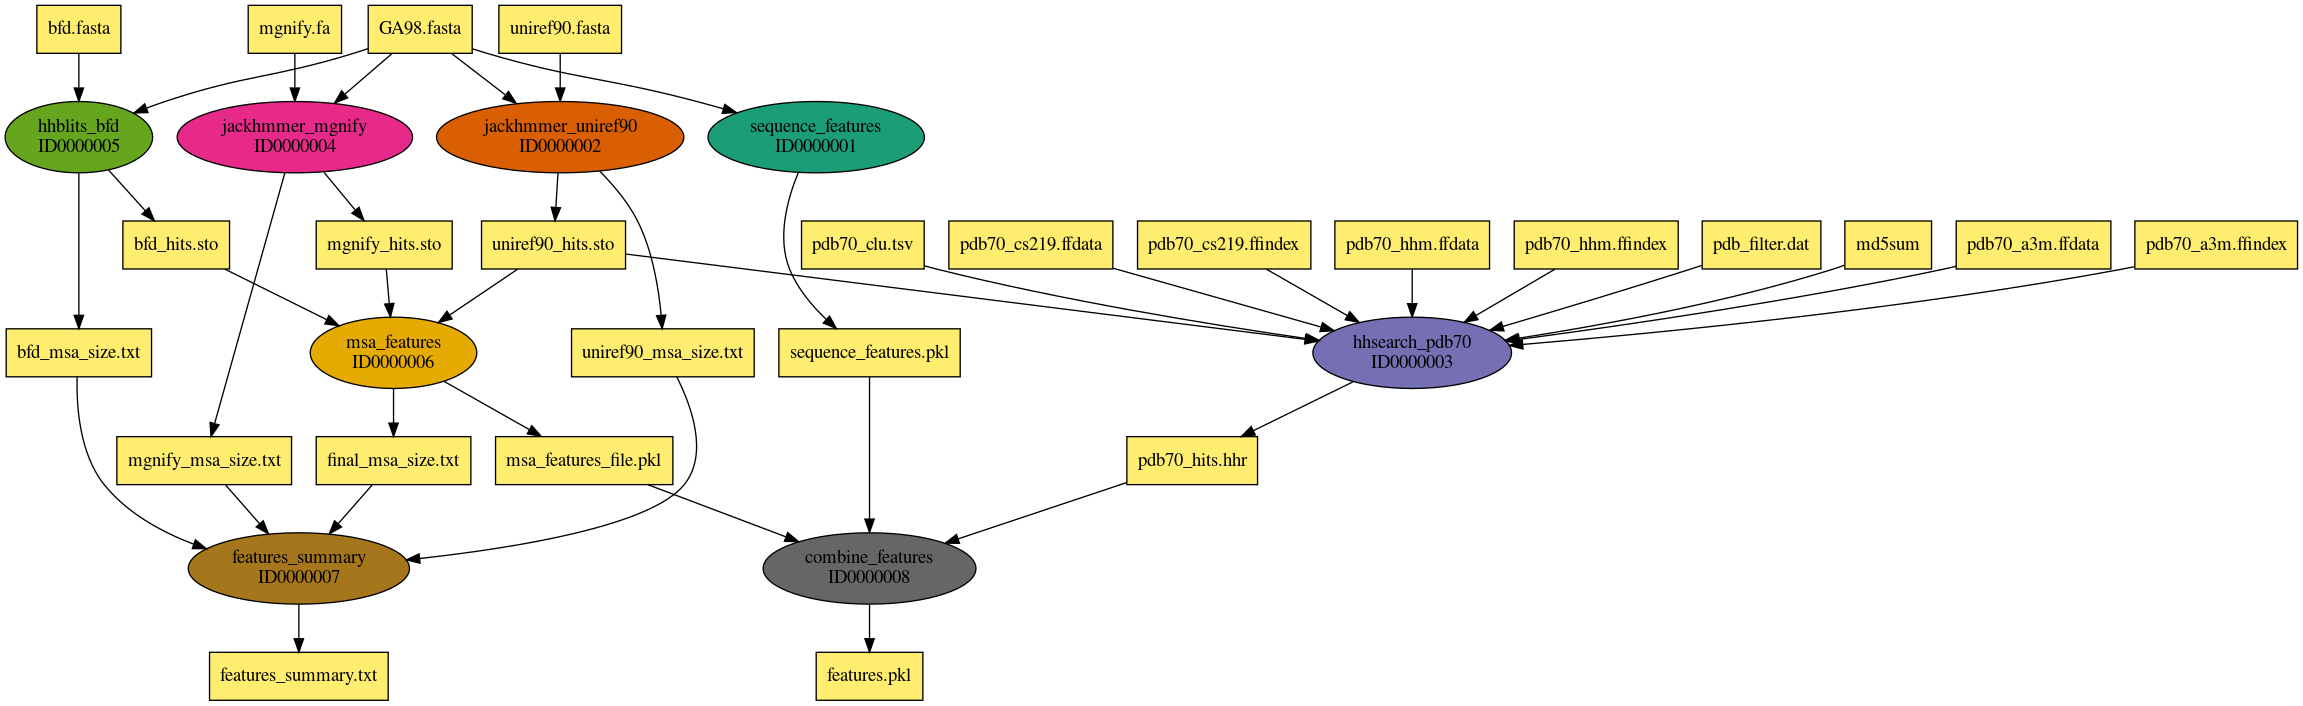

In [9]:
try:
    wf.write()
    wf.graph(include_files=True, label="xform-id", output="wf_graph.png")
except PegasusClientError as e:
    print(e)

Image(filename='wf_graph.png')

In [10]:
try:
    wf.plan(submit=True).wait()
except PegasusClientError as e:
    print(e)


################
# pegasus-plan #
################
2022.12.01 21:13:37.157 PST: [INFO]  Planner launched in the following directory /local-scratch/mzalam/alpha2
2022.12.01 21:13:37.166 PST: [INFO]  Planner invoked with following arguments --output-sites local --cleanup inplace --submit workflow.yml --json
2022.12.01 21:13:37.167 PST: [CONFIG]  Pegasus Properties set by the user
2022.12.01 21:13:37.168 PST: [CONFIG]  pegasus.home.bindir=/usr/bin
2022.12.01 21:13:37.168 PST: [CONFIG]  pegasus.home.schemadir=/usr/share/pegasus/schema
2022.12.01 21:13:37.168 PST: [CONFIG]  pegasus.home.sharedstatedir=/usr/share/pegasus
2022.12.01 21:13:37.168 PST: [CONFIG]  pegasus.home.sysconfdir=/etc/pegasus
2022.12.01 21:13:37.168 PST: [CONFIG]  pegasus.integrity.checking=none
2022.12.01 21:13:37.169 PST: [CONFIG]  pegasus.mode=development
2022.12.01 21:13:37.169 PST: [CONFIG]  pegasus.monitord.encoding=json
2022.12.01 21:13:38.229 PST: [INFO] event.pegasus.add.data-dependencies dax.id Alphafold-workfl

[#########################] 100.0% ..Success (Unready: 0, Completed: 24, Queued: 0, Running: 0, Failed: 0))


In [11]:
wf.statistics()


######################
# pegasus-statistics #
######################
Database version: '5.0.3dev' (sqlite:////local-scratch/mzalam/alpha2/mzalam/pegasus/Alphafold-workflow/run0001/Alphafold-workflow-0.stampede.db)

#
# Pegasus Workflow Management System - http://pegasus.isi.edu
#
# Workflow summary:
#   Summary of the workflow execution. It shows total
#   tasks/jobs/sub workflows run, how many succeeded/failed etc.
#   In case of hierarchical workflow the calculation shows the
#   statistics across all the sub workflows.It shows the following
#   statistics about tasks, jobs and sub workflows.
#     * Succeeded - total count of succeeded tasks/jobs/sub workflows.
#     * Failed - total count of failed tasks/jobs/sub workflows.
#     * Incomplete - total count of tasks/jobs/sub workflows that are
#       not in succeeded or failed state. This includes all the jobs
#       that are not submitted, submitted but not completed etc. This
#       is calculated as  difference between 'total'